# Movement around Corners

This notebook can be directly downloaded {download}`here <./corner.ipynb>` to run it locally.

In the following we'll investigate the movement of pedestrians around corners. When pedestrians walk around corners they are expected to slow down and take a path that is close to the corner. According to RiMEA Test 6 [1] a scenario is configured where **20 agents** move towards a **corner** at which they should turn to the left.

Let's begin by importing the required packages for our simulation:

In [1]:
import pathlib

import jupedsim as jps
import pedpy
from numpy.random import normal  # normal distribution of free movement speed
from shapely import Polygon

## Setting up the Geometry

According to the RiMEA Test we define a corridor with a width of 2 meters and a corner on halfway:

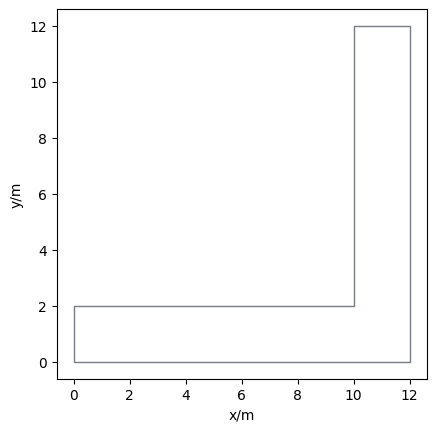

In [2]:
area = Polygon([(0, 0), (12, 0), (12, 12), (10, 12), (10, 2), (0, 2)])
walkable_area = pedpy.WalkableArea(area)
pedpy.plot_walkable_area(walkable_area=walkable_area).set_aspect("equal")

## Definition of Start Positions and Exit

Now we'll calculate the position of 20 agents in the lower left part of the geometry within an rectangle of 6 x 2 meters. For this purpose, we use a library function from JuPedSim that calclulates positions in a given polygon. We assume an agent size of 0.4 m (diameter) and set the distance parameters accordingly. The exit is defined in the upper right of the geometry.

In [3]:
spawning_area = Polygon([(0, 0), (6, 0), (6, 2), (0, 2)])
num_agents = 20
pos_in_spawning_area = jps.distributions.distribute_by_number(
    polygon=spawning_area,
    number_of_agents=num_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.2,
    seed=1,
)
exit_area = Polygon([(10, 11), (12, 11), (12, 12), (10, 12)])

Let's have a look at the basic simulation setup. The spawning area is shown in grey, the agents in blue and the exit area in red:

In [4]:
def plot_simulation_configuration(
    walkable_area, spawning_area, starting_positions, exit_area
):
    axes = pedpy.plot_walkable_area(walkable_area=walkable_area)
    axes.fill(*spawning_area.exterior.xy, color="lightgrey")
    axes.fill(*exit_area.exterior.xy, color="indianred")
    axes.scatter(*zip(*starting_positions))
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")

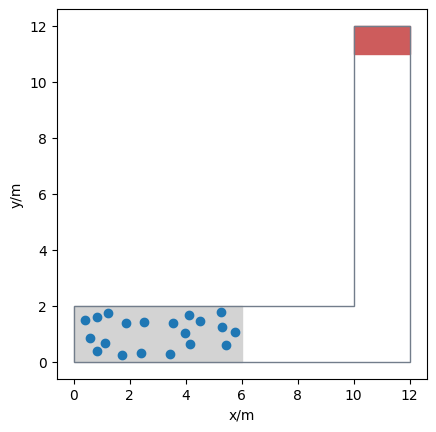

In [5]:
plot_simulation_configuration(
    walkable_area, spawning_area, pos_in_spawning_area, exit_area
)

## Setting up the Simulation and Routing Details

As a next step we create a simulation object, set the configuration for the operational model (collision-free speed model) and define the routes for the agents. Default values for the model parameters are set implicitly. For this scenario, only one journey is created as all agents should follow the same route.

In [6]:
trajectory_file = "corner.sqlite"  # output file
simulation = jps.Simulation(
    model=jps.CollisionFreeSpeedModel(),
    geometry=area,
    trajectory_writer=jps.SqliteTrajectoryWriter(
        output_file=pathlib.Path(trajectory_file)
    ),
)

In [7]:
exit_id = simulation.add_exit_stage(exit_area.exterior.coords[:-1])
journey = jps.JourneyDescription([exit_id])
journey_id = simulation.add_journey(journey)

## Agent Parameters and Executing the Simulation

As a next step we define the agent parameters and add them to the simulation. They share the same journey and model parameters except for the starting position and free movement speed which is normally distributed. After adding the agents, the simulation is started and iterates until all agents have reached the exit.

In [8]:
v_distribution = normal(1.34, 0.05, num_agents)

for pos, v0 in zip(pos_in_spawning_area, v_distribution):
    simulation.add_agent(
        jps.CollisionFreeSpeedModelAgentParameters(
            journey_id=journey_id,
            stage_id=exit_id,
            position=pos,
            desired_speed=v0,
        )
    )

while simulation.agent_count() > 0:
    simulation.iterate()

## Visualizing the Trajectories


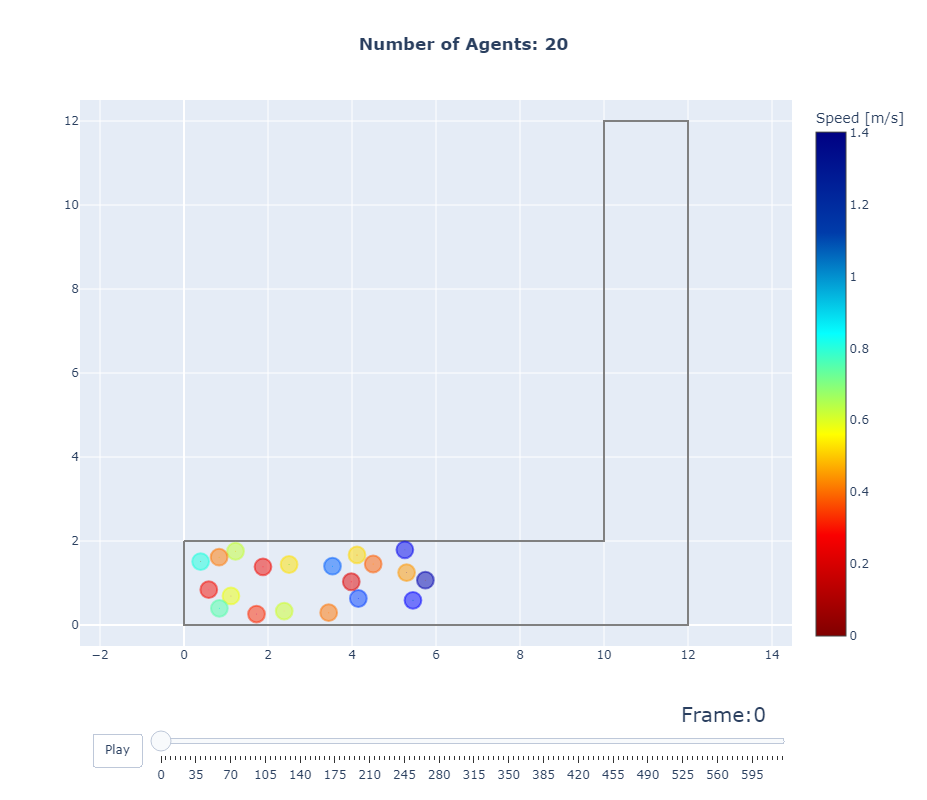

In [9]:
from jupedsim.internal.notebook_utils import animate, read_sqlite_file

trajectory_data, walkable_area = read_sqlite_file(trajectory_file)
animate(trajectory_data, walkable_area, every_nth_frame=5)